## Import modules

In [1]:
from ect import ECT, EmbeddedGraph # for calculating the ECT
import phate # for using PHATE # pip install --user phate
import scprep # for 3D visualizations of PHATE

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import pandas as pd # for dataframes and metadata
import numpy as np # for working with arrays
import os # for working with file names and paths
from pathlib import Path # for working with file names and paths
from scipy.spatial import ConvexHull # for convex hull in solidity function
from sklearn.decomposition import PCA # for PCA for width-to-length calculation

# Read in data, calculate aspect ratio and solidity, create ECT

## Define functions

In [2]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def solidity(lf):
    """
    For leaf coordinates in a 2D array, return solidity
    """
    hull = ConvexHull(lf) # calculate convex hull 
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(lf[:,0], lf[:,1]) # calculate area
    convex_area = poly_area(lf[vertices,0], lf[vertices,1]) # calculate convex area
    return area / convex_area  # calculate solidity and return

def wl_ratio(lf):
    """
    For leaf coordinates in a 2D array, return the width-to-length ratio
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(lf) # fit PCA to find longest axis
    pca_scores = pca.transform(lf) # retrieve PCA scores 
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    return width/length

In [3]:
# select path of input data
mypath = 'outline_input' 

# select path of output data
# this path may not exist yet
mypath_output = 'ect_output'

# select the number of ECT directions and thresholds
num_dirs = 32
num_thresh = 48

# lists to store data
paths_list = [] # list to store paths
wl_ratio_list = [] # list to store width-to-length ratio values
solidity_list = [] # list to store solidity values

# loop through file system
classes = []
class_count = 0

# this code loops through all the sub-directories in the outline input folder
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')

    # for each of the files in the current sub-directory
    for name in files:
        input_filedir = os.path.join(path, name) # get the current path

        # load in the current leaf
        # these are .txt files, so we use np.loadtxt()
        leaf = np.loadtxt(input_filedir)
        # if we were using .npy files for coordinate data, we would use np.load() instead
        #leaf = np.load(input_filedir)

        # calculate the wl ratio and solidity and save to list
        wl_ratio_list.append(wl_ratio(leaf))
        solidity_list.append(solidity(leaf))
    
        G = EmbeddedGraph() # define a graph object for the leaf
        G.add_cycle(leaf)  # use coordinates to add vertices (and embedding coordinates) to the graph object
        G.set_PCA_coordinates( center_type='min_max', scale_radius=1) # scale the leaf using PCA
        myect = ECT(num_dirs = num_dirs, num_thresh=num_thresh) # calculate ECT
        myect.set_bounding_radius(1) # scale ECT to radius
        M = myect.calculateECT(G) # save ECT matrix as a numpy array

        # save the ECT matrix as a numpy file
        output_filedir = os.path.join(mypath_output+ input_filedir[len(mypath):])
        Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
        np.save(output_filedir[:-4]+".npy", M) # note: removing ".txt" by indexing and adding ".npy"
        # if you wanted a txt file use np.savetxt()

        # save the path of the file so we can find it later
        paths_list.append(output_filedir[:-4]+".npy")
        
    print('Saving the ECT of directory in ', path, '...')

Computing ECT of files in  outline_input ...
There are  0  samples to load in this directory.
Saving the ECT of directory in  outline_input ...
Computing ECT of files in  outline_input/leaves ...
There are  23  samples to load in this directory.
Saving the ECT of directory in  outline_input/leaves ...
Computing ECT of files in  outline_input/figures ...
There are  2  samples to load in this directory.
Saving the ECT of directory in  outline_input/figures ...
Computing ECT of files in  outline_input/hearts ...
There are  94  samples to load in this directory.
Saving the ECT of directory in  outline_input/hearts ...


We save the associated data and paths to the files as a dataframe `.csv` files

In [4]:
# build a pandas dataframe using a dictionary
df = pd.DataFrame({
    "path":paths_list,
    "wl_ratio":wl_ratio_list,
    "solidity":solidity_list
})

# save the csv
df.to_csv("matisse_df.csv")

# Read in ECTs, visualize and analyze data

For visualization purposes, we read in the ECT data into an array. We can use the file names we saved in the dataframe

In [5]:
# read in csv file as pandas dataframe
df = pd.read_csv("./matisse_df.csv")

Maybe we want the class of each shape. We can use the file name to see if the file is hearts, leaves, or figures

In [6]:
class_list = [] # store the class of the object

for i in range(len(df)): # for the length of df
    if "leaves" in df["path"].iloc[i]: # if leaves in current file path
        class_list.append("leaf")
    elif "hearts" in df["path"].iloc[i]:
        class_list.append("heart")
    elif "figures" in df["path"].iloc[i]:
        class_list.append("figure")

df["class"] = class_list # add class ID to df

df.head() # head and check df

,Unnamed: 0,path,wl_ratio,solidity,class
0,0,ect_output/leaves/006_leaf.npy,0.629248,0.693472,leaf
1,1,ect_output/leaves/007_leaf.npy,0.620939,0.720756,leaf
2,2,ect_output/leaves/025_leaf.npy,0.733081,0.632858,leaf
3,3,ect_output/leaves/024_leaf.npy,0.708842,0.642169,leaf
4,4,ect_output/leaves/011_leaf.npy,0.845979,0.588362,leaf


Let's make a scatterplot with the information in df

<Axes: xlabel='wl_ratio', ylabel='solidity'>

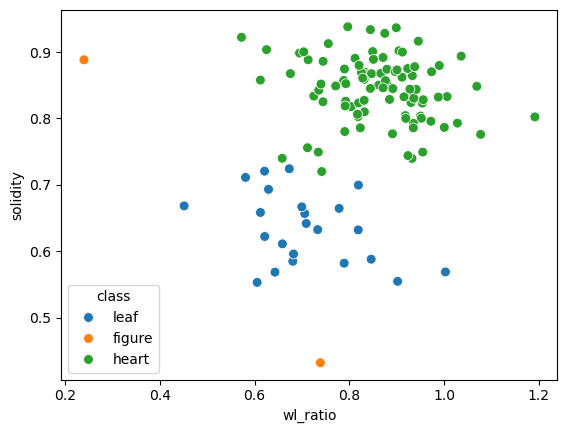

In [7]:
sns.scatterplot(data=df, x="wl_ratio", y="solidity", hue="class", s=50)

Let us read back in the ECT data and create an array

In [8]:
# create an array of zeros to store data
# specify the dimensions:
# number of files x num dirs x num thresh
ect_arr = np.zeros((len(df),num_dirs,num_thresh)) 

for i in range(len(df)): # for the length of df, or the number of files
    curr_file = df["path"].iloc[i] # get current file
    arr = np.load(curr_file) # read in current file
    ect_arr[i,:,:] = arr # save to array

In [9]:
# check that it worked
ect_arr

array([[[0., 0., 2., ..., 1., 0., 0.],
        [0., 2., 2., ..., 3., 0., 0.],
        [0., 3., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 2., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 1., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 1., 0.],
        ...,
        [0., 0., 2., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 2., ..., 2., 0., 0.],
        [0., 3., 2., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 3., 1., ..., 1., 0., 0.],
        [0., 1., 1., ..., 1., 0., 0.],
        [0., 0., 1., ..., 0., 0.

# PHATE (Potential of Heat-diffusion for Affinity-based Trajectory Embedding)

Now that we have the ECT stored in an array, we can do some analysis.

Before we perform PHATE, we need to "flatten" the ECT array to different dimensions

In [10]:
flat_arr = np.reshape(ect_arr, (np.shape(ect_arr)[0],np.shape(ect_arr)[1]*np.shape(ect_arr)[2]))

The following is from ***[read the docs](https://phate.readthedocs.io/en/stable/)*** for PHATE:

- n_components (int, optional, default: 2) – number of dimensions in which the data will be embedded
- knn (int, optional, default: 5) – number of nearest neighbors on which to build kernel
- decay (int, optional, default: 40) – sets decay rate of kernel tails. If None, alpha decaying kernel is not used
- n_landmark (int, optional, default: 2000) – number of landmarks to use in fast PHATE
- t (int, optional, default: 'auto') – power to which the diffusion operator is powered. This sets the level of diffusion. If ‘auto’, t is selected according to the knee point in the Von Neumann Entropy of the diffusion operator
- gamma (float, optional, default: 1) – Informational distance constant between -1 and 1. gamma=1 gives the PHATE log potential, gamma=0 gives a square root potential.
- n_pca (int, optional, default: 100) – Number of principal components to use for calculating neighborhoods. For extremely large datasets, using n_pca < 20 allows neighborhoods to be calculated in roughly log(n_samples) time.
- mds_solver ({'sgd', 'smacof'}, optional (default: 'sgd')) – which solver to use for metric MDS. SGD is substantially faster, but produces slightly less optimal results. Note that SMACOF was used for all figures in the PHATE paper.
- knn_dist (string, optional, default: 'euclidean') – recommended values: ‘euclidean’, ‘cosine’, ‘precomputed’ Any metric from scipy.spatial.distance can be used distance metric for building kNN graph. Custom distance functions of form f(x, y) = d are also accepted. If ‘precomputed’, data should be an n_samples x n_samples distance or affinity matrix. Distance matrices are assumed to have zeros down the diagonal, while affinity matrices are assumed to have non-zero values down the diagonal. This is detected automatically using data[0,0]. You can override this detection with knn_dist=’precomputed_distance’ or knn_dist=’precomputed_affinity’.
- knn_max (int, optional, default: None) – Maximum number of neighbors for which alpha decaying kernel is computed for each point. For very large datasets, setting knn_max to a small multiple of knn can speed up computation significantly.
- mds_dist (string, optional, default: 'euclidean') – Distance metric for MDS. Recommended values: ‘euclidean’ and ‘cosine’ Any metric from scipy.spatial.distance can be used. Custom distance functions of form f(x, y) = d are also accepted
- mds (string, optional, default: 'metric') – choose from [‘classic’, ‘metric’, ‘nonmetric’]. Selects which MDS algorithm is used for dimensionality reduction
- n_jobs (integer, optional, default: 1) – The number of jobs to use for the computation. If -1 all CPUs are used. If 1 is given, no parallel computing code is used at all, which is useful for debugging. For n_jobs below -1, (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one are used
- random_state (integer or numpy.RandomState, optional, default: None) – The generator used to initialize SMACOF (metric, nonmetric) MDS If an integer is given, it fixes the seed Defaults to the global numpy random number generator
- verbose (int or boolean, optional (default: 1)) – If True or > 0, print status messages
- potential_method (deprecated.) – Use gamma=1 for log transformation and gamma=0 for square root transformation.
- kwargs (additional arguments for graphtools.Graph) –

#### PHATE in 2 dimensions

In [11]:
# create the PHATE embedding and transform
phate_operator = phate.PHATE(n_components=2)
phate_ect = phate_operator.fit_transform(flat_arr)

Calculating PHATE...
  Running PHATE on 119 observations and 1536 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.08 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.09 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.01 seconds.
Calculated PHATE in 0.13 seconds.


We add the PHATE1 and PHATE2 axes to the df

In [12]:
df["2DPHATE1"] = phate_ect[:,0]
df["2DPHATE2"] = phate_ect[:,1]

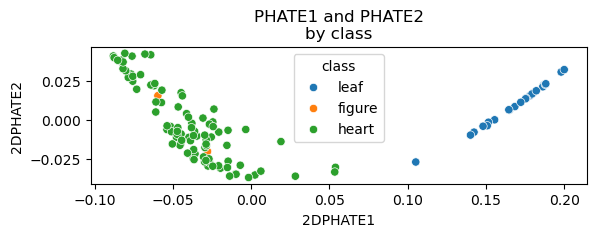

In [13]:
sns.scatterplot(data=df, x="2DPHATE1", y="2DPHATE2", hue="class", legend=True)
plt.title("PHATE1 and PHATE2\nby class")
plt.gca().set_aspect("equal")

#### PHATE in 3 dimensions

In [72]:
# create the PHATE embedding and transform
phate_operator = phate.PHATE(n_components=3)
phate_ect = phate_operator.fit_transform(flat_arr)

Calculating PHATE...
  Running PHATE on 119 observations and 1536 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.05 seconds.
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.06 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.08 seconds.
Calculated PHATE in 0.16 seconds.


We add the PHATE1, PHATE2, and PHATE3 axes to the df

In [75]:
df["3DPHATE1"] = phate_ect[:,0]
df["3DPHATE2"] = phate_ect[:,1]
df["3DPHATE3"] = phate_ect[:,2]

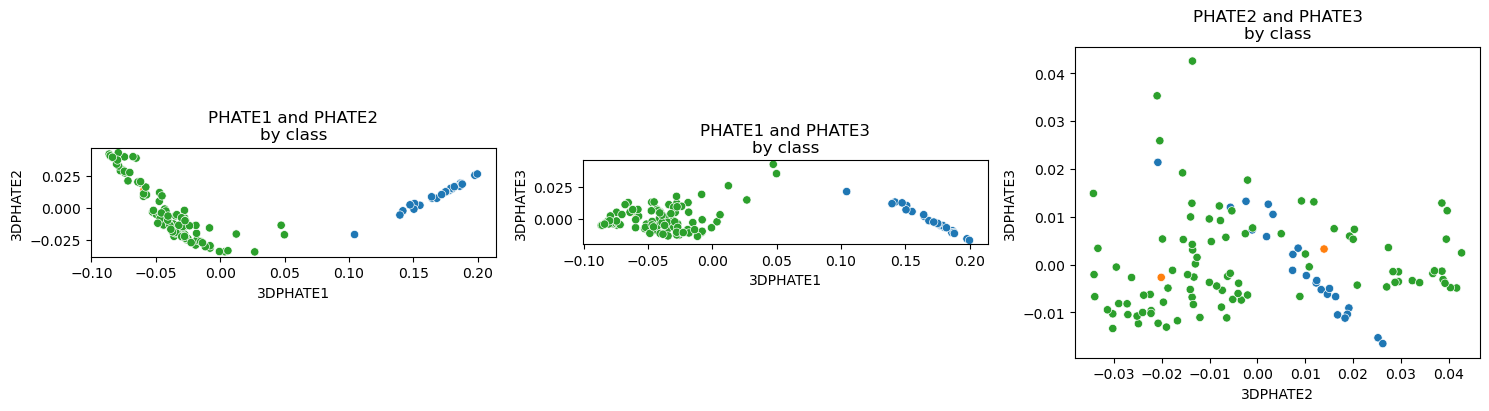

In [81]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.scatterplot(data=df, x="3DPHATE1", y="3DPHATE2", hue="class", legend=False)
plt.title("PHATE1 and PHATE2\nby class")
plt.gca().set_aspect("equal")

plt.subplot(1,3,2)
sns.scatterplot(data=df, x="3DPHATE1", y="3DPHATE3", hue="class", legend=False)
plt.title("PHATE1 and PHATE3\nby class")
plt.gca().set_aspect("equal")

plt.subplot(1,3,3)
sns.scatterplot(data=df, x="3DPHATE2", y="3DPHATE3", hue="class", legend=False)
plt.title("PHATE2 and PHATE3\nby class")
plt.gca().set_aspect("equal")

plt.tight_layout()

We can also make 3D animations

In [ ]:
sample_labels = df["class"]

# for a static plot use "scatter3d" instead of "rotate_scatter3d"
# this saves to GIF and produces animation
scprep.plot.rotate_scatter3d(phate_ect, c=sample_labels, 
                             figsize=(8,6), 
                             ticks=True, 
                             label_prefix="PHATE")
                             #filename="all_datasets.gif", s=5) # if you want to save to file

In [ ]:
sample_labels = df["wl_ratio"]

# for a static plot use "scatter3d" instead of "rotate_scatter3d"
# this saves to GIF and produces animation
scprep.plot.rotate_scatter3d(phate_ect, c=sample_labels, 
                             figsize=(8,6), 
                             ticks=True, 
                             label_prefix="PHATE")
                             #filename="all_datasets.gif", s=5) # if you want to save to file

In [ ]:
sample_labels = df["solidity"]

# for a static plot use "scatter3d" instead of "rotate_scatter3d"
# this saves to GIF and produces animation
scprep.plot.rotate_scatter3d(phate_ect, c=sample_labels, 
                             figsize=(8,6), 
                             ticks=True, 
                             label_prefix="PHATE")
                             #filename="all_datasets.gif", s=5) # if you want to save to file